In [1]:
import sys
sys.path.insert(0, "../../")

from src.instruction_utility import *
from src.utility import *

import pandas as pd

import matplotlib.pyplot as plt

Lets get all metadata files in "models/":

In [2]:
candidate_files = []
for root, directory, files in os.walk(os.path.join(get_project_dir(), "models")):
    for file in files:
        if file.endswith(".meta"):
            if "checkpoint" not in file:
                candidate_files.append(file)

Now filter all the files that have written logs, which are not None and also provide TopKValidation predictions:

In [3]:
candidate_files

['simple_conv2d_embedding_size_16_angular_d-0.meta',
 'simple_conv2d_embedding_size_12_angular_d.meta',
 'mobilenet_v2_frozen.meta',
 'simple_conv2d_embedding_size_16_angular_d.meta',
 'simple_conv2d_embedding_size_32_angular_d.meta',
 'simple_conv2d_embedding_size_8_angular_d.meta',
 'simple_conv2d_embedding_size_16_angular_d-1.meta',
 'simple_conv2d_embedding_size_20_angular_d.meta',
 'simple_conv2d_embedding_size_8.meta',
 'simple_conv2d_embedding_size_256.meta',
 'simple_conv2d_embedding_size_32-1.meta',
 'VAE_conv2d_input_224_embedding_512.meta',
 'simple_conv2d_embedding_size_14_angular_d.meta',
 'simple_conv2d_embedding_size_64.meta',
 'simple_conv2d_embedding_size_32.meta',
 'simple_conv2d_embedding_size_64_angular_d.meta',
 'simple_conv2d_embedding_size_16.meta',
 'simple_conv2d_embedding_size_128.meta']

In [4]:
valid_metadata = []

for file in candidate_files:
    metadata = load_metadata(file)
    if "logs" in metadata.keys():
        if metadata["logs"] != "None":
            if "TopKValidation" in metadata["logs"].keys():
                valid_metadata.append(metadata)

In [5]:
candidate_files

['simple_conv2d_embedding_size_16_angular_d-0.meta',
 'simple_conv2d_embedding_size_12_angular_d.meta',
 'mobilenet_v2_frozen.meta',
 'simple_conv2d_embedding_size_16_angular_d.meta',
 'simple_conv2d_embedding_size_32_angular_d.meta',
 'simple_conv2d_embedding_size_8_angular_d.meta',
 'simple_conv2d_embedding_size_16_angular_d-1.meta',
 'simple_conv2d_embedding_size_20_angular_d.meta',
 'simple_conv2d_embedding_size_8.meta',
 'simple_conv2d_embedding_size_256.meta',
 'simple_conv2d_embedding_size_32-1.meta',
 'VAE_conv2d_input_224_embedding_512.meta',
 'simple_conv2d_embedding_size_14_angular_d.meta',
 'simple_conv2d_embedding_size_64.meta',
 'simple_conv2d_embedding_size_32.meta',
 'simple_conv2d_embedding_size_64_angular_d.meta',
 'simple_conv2d_embedding_size_16.meta',
 'simple_conv2d_embedding_size_128.meta']

# Best Top K  Scores

In [6]:
def best_top_k_from_meta(metadata):
    topk = metadata["logs"]["TopKValidation"]
    best_top_k = {
        "top_k_sum": 0.0,
        "top_k_sum_epoch": 0.0,
    }

    for epoch in topk.keys():
        top_k_sum = 0.
        for k in topk[epoch].keys():
            if k in best_top_k.keys():
                if best_top_k[k] < topk[epoch][k]:
                    best_top_k[k] = topk[epoch][k]
                    best_top_k[k+"_epoch"] = epoch
            else:
                best_top_k[k] = topk[epoch][k]
                best_top_k[k+"_epoch"] = epoch
            top_k_sum += topk[epoch][k]

        if best_top_k["top_k_sum"] < top_k_sum:
            best_top_k["top_k_sum"] = top_k_sum
            best_top_k["top_k_sum_epoch"] = epoch
    return best_top_k
    
best_top_k_from_meta(valid_metadata[0])

{'top_k_sum': 1.416208104052026,
 'top_k_sum_epoch': '11',
 'top_1': 0.3609304652326163,
 'top_1_epoch': '11',
 'top_5': 0.4969984992496248,
 'top_5_epoch': '11',
 'top_10': 0.5627813906953477,
 'top_10_epoch': '27'}

In [7]:
tmp_list = []
for metadata in valid_metadata:
    tmp_dict = best_top_k_from_meta(metadata)
    tmp_dict["saved_model"] = metadata["saved_model"]
    tmp_list.append(tmp_dict)
df = pd.DataFrame(tmp_list)

In [8]:
pd.options.display.max_colwidth = 60  # show long strings
df.sort_values(by="top_1", ascending=False)

,top_k_sum,top_k_sum_epoch,top_1,top_1_epoch,top_5,top_5_epoch,top_10,top_10_epoch,saved_model
0,1.416208,11,0.360930,11,0.496998,11,0.562781,27,models/simple_conv2d_embedding_size_16_angular_d-0.h5
6,1.359180,19,0.341671,23,0.480740,31,0.542771,31,models/simple_conv2d_embedding_size_20_angular_d.h5
9,1.350675,23,0.334667,15,0.478239,23,0.538519,23,models/simple_conv2d_embedding_size_14_angular_d.h5
5,1.344172,27,0.333667,15,0.475738,27,0.539520,27,models/simple_conv2d_embedding_size_16_angular_d-1.h5
1,1.324912,15,0.323912,15,0.467734,15,0.533267,15,models/simple_conv2d_embedding_size_12_angular_d.h5
2,1.120058,47,0.248256,46,0.399419,47,0.476453,47,models/simple_conv2d_embedding_size_16_angular_d.h5
11,0.996802,31,0.211337,31,0.357267,31,0.428198,31,models/simple_conv2d_embedding_size_32.h5
8,0.964244,27,0.206395,27,0.344186,31,0.417442,31,models/simple_conv2d_embedding_size_256.h5
14,0.967442,19,0.203198,19,0.346221,19,0.418023,19,models/simple_conv2d_embedding_size_128.h5
10,0.947674,23,0.202907,23,0.336628,23,0.410756,27,models/simple_conv2d_embedding_size_64.h5


In [9]:
valid_metadata[0]

{'saved_model': 'models/simple_conv2d_embedding_size_16_angular_d-0.h5',
 'tensorboard_log_dir': 'reports/tensorboard_logs/simple_conv2d_embedding_size_16_angular_d-0',
 'best_top_1_model': 'models/simple_conv2d_embedding_size_16_angular_d-0_best_top_1.h5',
 'git_commit': '8577de6',
 'instruction': {'train_data': {'dataframe': 'data/processed/category_id_1_min_pair_count_10_deepfashion_train.joblib',
   'factory': 'src.data.triplet_dataset_factory.TripletDatasetFactory',
   'kwargs': {'batch_size': 64, 'data_slice_ratio': 1.0, 'shuffle': 'True'}},
  'validation_data': 'None',
  'model': {'factory': 'src.models.simple_conv2d_triplet_model_factory.SimpleConv2DTripletModelFactory',
   'kwargs': {'input_shape': [224, 224, 3],
    'embedding_size': 16,
    'filters_per_conv_layer': [16, 32, 64, 128, 256],
    'size_dense_layers': [512, 256]},
   'load': 'None',
   'fit': {'kwargs': {'epochs': 50}}},
  'loss': {'loss': 'tensorflow_addons.losses.TripletSemiHardLoss',
   'kwargs': {'distance_m

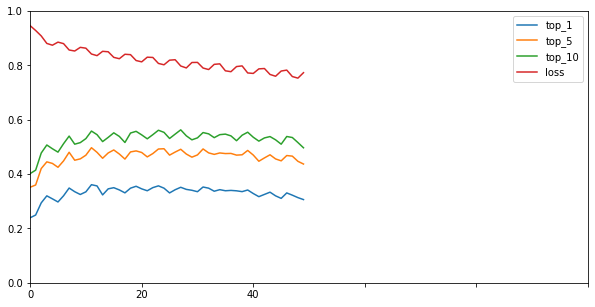

In [10]:
def plot_full_logs(metadata):
    tmp_df = pd.DataFrame(metadata["logs"]["TopKValidation"])
    tmp_df=tmp_df.transpose()
    tmp_df["loss"] = metadata["logs"]["history"]["loss"]
    tmp_df.plot(xlim=(0,100),ylim=(0,1), figsize=(10,5))

plot_full_logs(valid_metadata[0])